In [1]:
print("meowmeow")

print("hello?")

print("hehehaha")

meowmeow
hello?
hehehaha


In [3]:
print("kaiyi test")

print("weeeeeee")
print("weyuwuye")

kaiyi test
weeeeeee
weyuwuye


In [2]:
import cv2 # Will be used for edge detection further on
import os 
import numpy as np  # For numerical operations
from PIL import Image, ImageEnhance  # For image loading and augmentation
import matplotlib.pyplot as plt  # For visualization
from sklearn.preprocessing import LabelEncoder  # For encoding labels
import random  # For random transformations


In [275]:
from PIL import Image, ImageEnhance, ImageFilter


# Set Parameters
target_size = (224, 224)  # Standard input size for CNN
rotation_prob = 0.4  # 40% chance of rotation
saturation_prob = 0.5  # 50% chance of saturation change
min_saturation = 0.7  # Min saturation level
max_saturation = 1.3  # Max saturation level
blur_prob = 0.5  # 50% chance of blur
noise_prob = 0.5  # 50% chance of noise
min_crop_size = (70, 70)  # Minimum size of crop to avoid cutting off too much
padding = 80  # Padding to avoid cutting off important parts of the image
border_threshold = 5 # For the black border threshold count

# To crop out the edges
def auto_crop(img):
    """Ensure we receive a proper numpy array"""
    if isinstance(img, Image.Image):
        img_cv = np.array(img)
    else:
        img_cv = img.copy()
        
    if len(img_cv.shape) == 3:
        gray = cv2.cvtColor(img_cv, cv2.COLOR_RGB2GRAY)
    else:
        gray = img_cv
        
    # Rest of your auto_crop function remains the same...
    edges = cv2.Canny(gray, threshold1=60, threshold2=160)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = [c for c in contours if cv2.contourArea(c) > 200]
    
    if contours:
        x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
        x = max(0, x - padding)
        y = max(0, y - padding)
        cropped = img.crop((x, y, x + w + padding, y + h + padding))
        return cropped if cropped.size[0] >= min_crop_size[0] and cropped.size[1] >= min_crop_size[1] else img
    return img


# Function to resize image
def resize_image(img, target_size=(224, 224)):
    return img.resize(target_size, Image.LANCZOS)


# Function to apply random blur to an image
def apply_random_blur(img, prob=0.5):
    if random.random() < prob:
        radius = random.uniform(0.1, 2.0)  # Random blur radius
        return img.filter(ImageFilter.GaussianBlur(radius))
    return img  # No blur

# Function to add random noise to an image
def add_random_noise(img, prob=0.5):
    if random.random() < prob:
        img_array = np.array(img)
        noise = np.random.normal(0, 0.1, img_array.shape)  # Add Gaussian noise
        noisy_img_array = img_array + noise * 255  # Scale noise
        noisy_img_array = np.clip(noisy_img_array, 0, 255).astype(np.uint8)  # Ensure values are valid
        return Image.fromarray(noisy_img_array)
    return img  # No noise

# Function to adjust saturation
def adjust_saturation(img, min_factor=0.7, max_factor=1.3, prob=0.5):
    if random.random() < prob:
        factor = random.uniform(min_factor, max_factor)
        enhancer = ImageEnhance.Color(img)
        return enhancer.enhance(factor)
    return img  # No change


def rotate_image(img, max_angle=10, rotation_prob=0.4):
    """Random rotation with proper border handling"""
    if random.random() < rotation_prob:
        angle = random.uniform(-max_angle, max_angle)
        
        # Rotate on expanded canvas
        rotated = img.rotate(angle, expand=True, resample=Image.BILINEAR)
        
        # Convert to numpy array for border detection
        np_img = np.array(rotated)
        
        if np_img.ndim == 3:  # Color image
            # Find non-black pixels (any channel > threshold)
            non_black = np.any(np_img > border_threshold, axis=2)
        else:  # Grayscale
            non_black = np_img > border_threshold
            
        if np.any(non_black):
            # Get bounding box coordinates
            rows = np.any(non_black, axis=1)
            cols = np.any(non_black, axis=0)
            y_min, y_max = np.where(rows)[0][[0, -1]]
            x_min, x_max = np.where(cols)[0][[0, -1]]
            
            # Crop and convert back to PIL
            cropped = rotated.crop((x_min, y_min, x_max, y_max))
            return cropped.resize(target_size, Image.LANCZOS)
    
    # Return original if no rotation or if border removal failed
    return img.resize(target_size, Image.LANCZOS) if rotation_prob else img






In [254]:
train_folder = "Train"  # Change to your dataset path
train_images = []
train_labels = []

for img_file in os.listdir(train_folder):
    if img_file.endswith(".png"):
        img_path = os.path.join(train_folder, img_file)

        # Load image using PIL
        img = Image.open(img_path).convert("RGB")

        # Extract class label from filename
        class_label = int(img_file.split("__")[0])

        # Apply preprocessing
        img = rotate_image(img, max_angle=10, rotation_prob=rotation_prob)  # Selective Rotation
        img = auto_crop(img)  # Crop after rotation
        img = adjust_saturation(img, min_factor=min_saturation, max_factor=max_saturation, prob=saturation_prob)  # Selective Saturation
        img = apply_random_blur(img, prob=blur_prob)  # Random image blurring
        img = add_random_noise(img, prob=noise_prob)  # Apply random noise to some images
        img = resize_image(img, target_size)  # Resize after all transformations

        
     
        
        # Convert image to NumPy array and normalize
        img = np.array(img) / 255.0  

        # Store processed image and label
        train_images.append(img)
        train_labels.append(class_label)

# Convert to NumPy arrays
X_train = np.array(train_images)
y_train = np.array(train_labels)
 


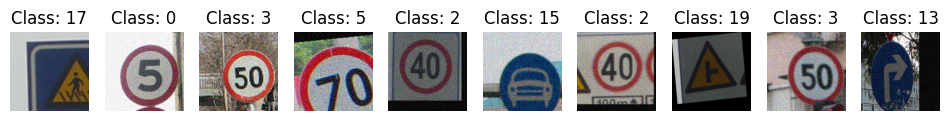

In [274]:
num_samples = 10  # Number of images to display
random_indices = random.sample(range(len(X_train)), num_samples)

plt.figure(figsize=(12, 6))
for i, idx in enumerate(random_indices):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(X_train[idx])  # Show image
    plt.title(f"Class: {y_train[idx]}")
    plt.axis("off")

plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy

#function for us to count the total number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

In [ ]:
#input_size = ??
#output_size = ??

class CNN(nn.Module):
    def __init__(self, input_size, n_features, output_size): #n_features = number of filters (feature maps)
        super(CNN, self).__init__()
        self.n_features = n_features
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_features, kernel_size=5) # input channel = 3 to allow for rgb image, update kernel size accordingly based on the input size
        self.conv2 = nn.Conv2d(n_features, n_features, kernel_size=5)
        self.fc1 = nn.Linear(n_features*4*4, 50)
        self.fc2 = nn.Linear(50, 10) #adjust input and output variables accordingly

    def forward(self, x):
        x = self.conv1(x) 
        x = F.relu(x) #using relu activation fn
        x = F.max_pool2d(x, kernel_size=2) # to downside the output (IF NEEDED since we doubled it jn)
        x = self.conv2(x) 
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*4*4) #flattens the multi-dimensional output from the convolutional and pooling layers into a 1D vector to feed into fc layers
        x = self.fc1(x) #fully connected layers at the end
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1) #apply log soft max to the output



In [ ]:
# Variables for our model
# (TO BE ADJUSTED BASED ON HOW WE WANT TO TRAIN THE MODEL)
batch_size = 64
num_classes = 10
learning_rate = 0.001
num_epochs = 20

In [ ]:
# Initialising the CNN model 
model = CNN(num_classes)

# Set Loss function with criterion (can change i think)
criterion = nn.CrossEntropyLoss()

# Set optimizer with optimizer (can change) 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  

total_step = len(train_loader)

In [ ]:
# TRAINING 
for epoch in range(num_epochs):
# Load in the data in batches using the train_loader object
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

In [ ]:
# TESTING 
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print('Accuracy of the network on the {} train images: {} %'.format(50000, 100 * correct / total))